In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from typing import List, Tuple, Iterable, Any
import matplotlib.pyplot as plt
import pandas as pd
import pint
from uncertainties.core import Variable
import cobra
from cobra.io import read_sbml_model
from cobra.flux_analysis import pfba, phenotype_phase_plane, flux_variability_analysis

plt.rcParams["font.family"] = "DejaVu Sans"
Q_ = pint.UnitRegistry()

def confidence_interval(x: Variable) -> Tuple[float, float]:
    """Get the minimum and maximum value assuming one standard deviation."""
    return (x.nominal_value - x.std_dev, x.nominal_value + x.std_dev)


In [2]:
wt_model = read_sbml_model("iML1515.xml")
# fix errors in the iML1515 model:
wt_model.remove_reactions(["POR5", "GLYCK"]) # these reactions are not present in E. coli
wt_model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1}) # transhydrogenase translocates only 1 proton (not 2)

cobra\core\group.py:109 UserWarning: need to pass in a list


In [3]:
# knock out the genes according to the fC1GAUX strain
# 1) glycine cleavage system
# 2) glycine hydroxymethyltransferase (same as serine hydroxymethyltransferase?)
# 3) PFL and OBTFL are removed to simulate aerobic conditions
model_fC1GAUX = wt_model.copy()
model_fC1GAUX.remove_reactions(["GLYCL", "GHMT2r"])

model_fC1GAUX.reactions.PFL.knock_out()
model_fC1GAUX.reactions.OBTFL.knock_out() # by pflB/tdcB

# based on gathered evidence, we remove FTHFLi (that uses formate to charge THF)
model_fC1GAUX.reactions.FTHFLi.knock_out()

# and we force FTHFD, GARFT, and AICART to be forward so nucleotides would not be degraded to make mlthf_c
model_fC1GAUX.reactions.FTHFD.bounds = (0.0, 1000.0) # purU
model_fC1GAUX.reactions.GARFT.bounds = (0.0, 1000.0) # purN
model_fC1GAUX.reactions.AICART.bounds = (0.0, 1000.0) # purH

# we change the thymidine periplasmic symporter reaction to be reversible,
# based on evidence for it (adding thymidine to the media rescues growth for certain conditions).
model_fC1GAUX.reactions.THYMt3pp.bounds = (-1000, 1000)

for rxn in model_fC1GAUX.boundary:
    if rxn.id in ["EX_co2_e", "EX_fald_e"]:
        rxn.bounds = (-1000, 1000)
    elif "C" in rxn.check_mass_balance(): # knock out all other carbon-related transporters
        rxn.bounds = (0, 1000)

# add the spontaneous reaction from THF + formaldehyde -> methylene-THF
rxn = cobra.Reaction(id="THFSPONT", name="spontaneous condensation of THF and formaldehyde", lower_bound=0, upper_bound=1000)
model_fC1GAUX.add_reaction(rxn)
rxn.add_metabolites({"thf_c": -1, "fald_c": -1, "mlthf_c": 1, "h2o_c": 1})

In [4]:
def add_import_reactions(model: cobra.Model, mets: List[str]) -> cobra.Model:
    new_model = model.copy()
    for met in mets:
        if not met:
            continue
        if f"EX_{met}" in new_model.reactions:
            new_model.reactions.get_by_id(f"EX_{met}").bounds = (-10, 1000)
        else:
            rxn = cobra.Reaction(id=f"EX_{met}", lower_bound=-10, upper_bound=10)
            new_model.add_reaction(rxn)
            rxn.add_metabolites({met: -1})
    return new_model


In [5]:
def plot_envelope(
        _model: cobra.core.model,
        target_reaction: str,
        ax: plt.Axes,
        label: str = None,
        color: Any = 'b',
        points: int = 20
) -> Q_.Measurement:
    
    model = _model.copy()
    prod_env_df = phenotype_phase_plane.production_envelope(model, target_reaction, points=points)
    
    ax.plot(prod_env_df.flux_minimum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=1, label='')
    ax.plot(prod_env_df.flux_maximum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=1, label='')

    ax.fill_betweenx(
        prod_env_df[target_reaction],
        prod_env_df.flux_minimum,
        prod_env_df.flux_maximum,
        linewidth=0,
        alpha=0.4,
        facecolor=color,
        label=label)
    target_rxn = model.reactions.get_by_id(target_reaction)
    
    target_rxn = model.reactions.get_by_id(target_reaction)

    # calculate the slope
    small_flux = Q_.Measurement(1e-3, 1e-6, "mmol/gram/hour")
    target_rxn.bounds = confidence_interval(small_flux.magnitude)
    sol = model.optimize("maximize")
    growth_rate = Q_.Measurement(sol.objective_value, 0, "1/hour")
    slope = small_flux / growth_rate
    return slope


In [6]:
growth_df = pd.DataFrame(
    data=[
        ["thymd_e", Q_.Measurement(0.03605, 0.00614, "1/hour")],
        ["thymd_e + met__L_e", Q_.Measurement(0.04662, 0.00414, "1/hour")],
    ],
    columns=["condition", "growth_rate"]
)
growth_df.set_index("condition")



,growth_rate
condition,
thymd_e,(0.036 +/- 0.006) 1 / hour
thymd_e + met__L_e,(0.047 +/- 0.004) 1 / hour


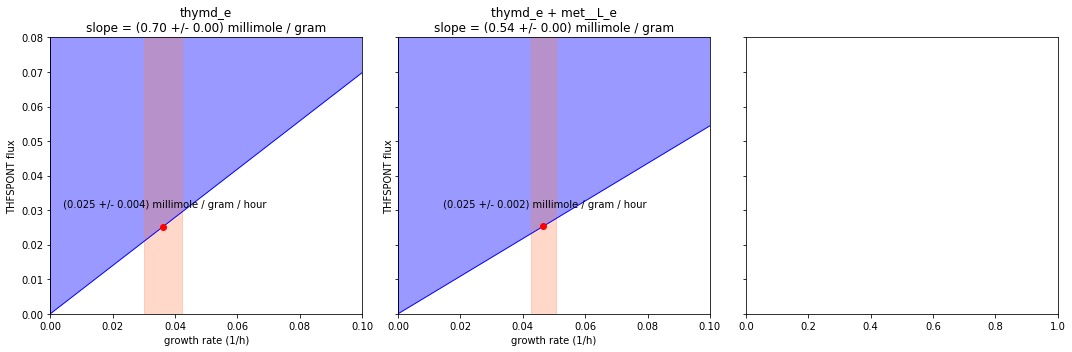

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for row, ax in zip(growth_df.itertuples(), axs.flat):
    gr = row.growth_rate
    mets = ["glc__D_e", "gly_e", "fald_e"] + row.condition.split(" + ")
    tmp_model = add_import_reactions(model_fC1GAUX, mets)
    slope = plot_envelope(tmp_model, "THFSPONT", ax, points=100)
    ax.set_xlabel("growth rate (1/h)")
    ax.set_ylabel("THFSPONT flux")
    ax.set_ylim(0, 0.08)
    ax.set_xlim(0, 0.1)
    ax.set_title(f"{row.condition}\nslope = {slope:.2g}")
    if gr > 0:
        gr.ito("1/hour")
        xmin, xmax = confidence_interval(gr.magnitude)
        ax.axvspan(xmin, xmax, color="coral", alpha=0.3)
        min_fald_uptake = gr * slope

        min_fald_uptake.ito("mmol/gram/hour")
        ax.plot(gr.nominal_value, min_fald_uptake.nominal_value,
                color="red", marker="o")
        ax.text(gr.nominal_value, min_fald_uptake.nominal_value+5e-3,
                f" {min_fald_uptake:.3f}", va="bottom", ha="center")

fig.tight_layout()


In [9]:
fig.savefig('PPP_figure.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
